## `Data Preparation`

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Packages:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score


In [2]:
train_df = pd.read_csv('Data/train.csv')

In [3]:
train_df.head(2)

,Unnamed: 0,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,7590-VHVEG,Female,0,Yes,No,1,No,NaN,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No


In [4]:
train_df.drop(columns=['customerid','Unnamed: 0'], axis = 1, inplace = True)

In [5]:
train_df.head(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No


In [6]:
train_df.isna().sum()

gender                0
seniorcitizen         0
partner               0
dependents            0
tenure                0
phoneservice          0
multiplelines       269
internetservice       0
onlinesecurity      651
onlinebackup        651
deviceprotection    651
techsupport         651
streamingtv         651
streamingmovies     651
contract              0
paperlessbilling      0
paymentmethod         0
monthlycharges        0
totalcharges          8
churn                 1
dtype: int64

#### To prevent data leakage, drop row with missing value in the churn column

In [7]:
train_df.dropna(subset='churn', inplace=True)

#### Check if the target variable is balanced

In [8]:
churn_distribution = train_df['churn'].value_counts().rename('total').reset_index()
churn_distribution

,churn,total
0,No,3706
1,Yes,1336


- Visualize the churn distribution

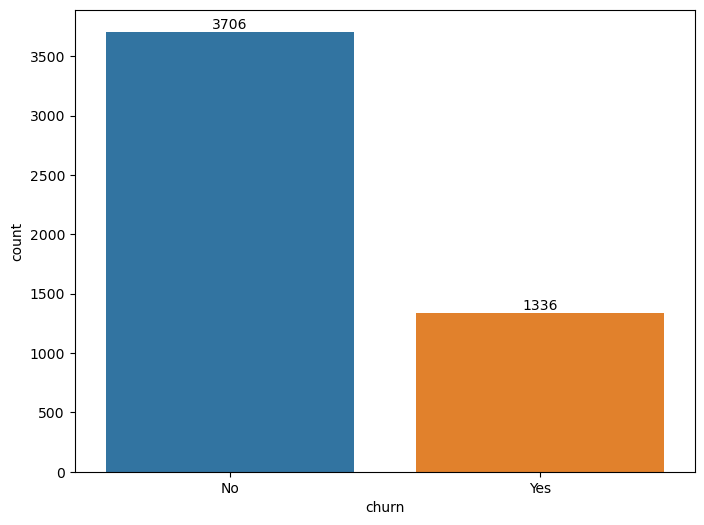

In [9]:
# Create the figure
plt.figure(figsize=(8, 6))

ax=sns.countplot(train_df, x='churn')

# Add count values on top of each bar
for p in ax.patches:
    count = int(p.get_height())  # Convert count to integer
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

#### Splitting the data into X and y variables

In [10]:
X = train_df.drop('churn', axis =1)
y = train_df[['churn']]

In [11]:
# DATA LEAKAGE ISSUES??? Do imputations only after train_test_split and only on y_train
# y_imputer = SimpleImputer(strategy='most_frequent', missing_values= pd.NA)
 
# y_imputed = y_imputer.fit_transform(y)
 
# y_imputed = pd.DataFrame(y_imputed, columns=y.columns)

In [12]:

# X_train_, X_eval_, y_train, y_eval =  train_test_split(X, y_imputed, test_size=0.2, random_state=42, stratify=y_imputed)

#### Splitting X and y into train and eval

In [13]:
X_train, X_eval, y_train, y_eval =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Encode y train and eval using Label encoder

In [14]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train['churn'])
y_eval_encoded = encoder.transform(y_eval['churn'])


### Preparing Pipelines

In [15]:
numerical_columns = X.select_dtypes('number').columns
categorical_columns = X.select_dtypes('object').columns

In [16]:
numerical_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy = 'median')),
    ('num_scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat-encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

### Modelling

In [17]:
from sklearn.ensemble import AdaBoostClassifier

models =[
    ('Decision_tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic_reg', LogisticRegression(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('random_forest', RandomForestClassifier(random_state = 42)),
    
]

# Creating dictionary for the models
all_pipelines = {}

# Create an empty DataFrame for metrics
metrics_table = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score'])

# Loop over models and create pipelines, fit models, and calculate metrics
for model_name, classifier in models:
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline on training data
    final_pipeline.fit(X_train, y_train_encoded)
    
    # Make predictions on the evaluation dataset
    y_pred = final_pipeline.predict(X_eval)

    # Calculate classification report metrics
    metrics = classification_report(y_eval_encoded, y_pred, output_dict=True)

    # Add all pipelines into all_pipeline dictionary
    all_pipelines[model_name] = final_pipeline
    
    # Extract metrics for the current model
    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']
    
    # Add metrics to metrics_table
    metrics_table.loc[len(metrics_table)] = [model_name, accuracy, precision, recall, f1_score]

# Display the metrics table
metrics_table.sort_values(ascending=False, by='f1_score')

,model_name,accuracy,precision,recall,f1_score
1,Logistic_reg,0.799802,0.794989,0.799802,0.796963
3,random_forest,0.786918,0.776866,0.786918,0.779906
2,knn,0.765114,0.764275,0.765114,0.764687
0,Decision_tree,0.723489,0.731998,0.723489,0.727303


In [18]:
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

all_confusion_matrix = {}

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_eval_encoded, y_pred)

all_confusion_matrix[model_name] = conf_matrix

In [20]:
all_confusion_matrix

{'random_forest': array([[658,  84],
        [131, 136]], dtype=int64)}

<Axes: >

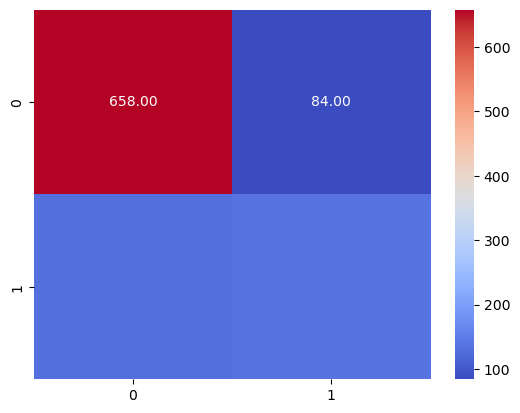

In [21]:
forest_matrix = all_confusion_matrix['random_forest']
sns.heatmap(forest_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')

#### Visualizing the ROC_AUC curve

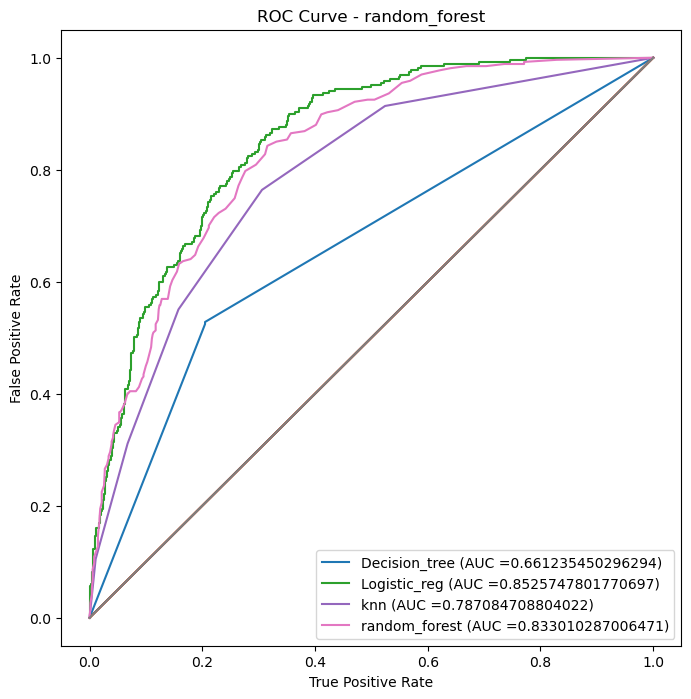

In [22]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize = (8,8))

# add confusion matrix to all pipelines
all_confusion_matrix = {}

all_roc_data = {}

for model_name, pipeline in all_pipelines.items():
    y_score = pipeline.predict_proba(X_eval)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_eval_encoded, y_score)

    roc_auc = auc(fpr, tpr)

    roc_data_df = pd.DataFrame({'False Positive rate': fpr, 'True Positive Rate': tpr, 'Thresholds': thresholds})

    all_roc_data[model_name] = roc_data_df

    ax.plot(fpr, tpr, label= f'{model_name} (AUC ={roc_auc})')

    ax.plot([0,1], [0,1])
    ax.set_ylabel('False Positive Rate')
    ax.set_xlabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}') 

plt.legend() 
plt.show()   




In [23]:
log_pipeline = all_pipelines['Logistic_reg']

In [24]:
all_roc_data['Logistic_reg'].tail(50)


,False Positive rate,True Positive Rate,Thresholds
234,0.365229,0.902622,0.185264
235,0.371968,0.902622,0.181366
236,0.371968,0.910112,0.180007
237,0.388140,0.910112,0.176782
238,0.388140,0.913858,0.176724
239,0.389488,0.913858,0.176569
240,0.389488,0.917603,0.176530
241,0.390836,0.917603,0.174629
242,0.390836,0.921348,0.173545
243,0.394879,0.921348,0.169180


<Axes: >

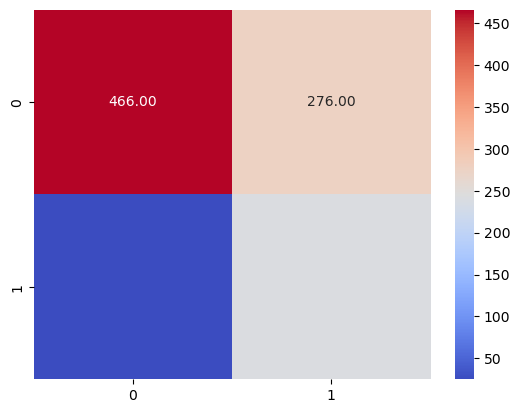

In [25]:
threshold = 0.180801

y_pred_proba = log_pipeline.predict_proba(X_eval)[:,1]

binary_predictions = (y_pred_proba > threshold).astype(int)
threshold_matrix = confusion_matrix(y_eval_encoded, binary_predictions)

# plot heat map of threshold conf_matrix
sns.heatmap(threshold_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')

#### Training Models on a Balanced Data Set

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

balanced_data_models =[
    ('Decision_tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic_reg', LogisticRegression(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('random_forest', RandomForestClassifier(random_state = 42))
]

# Creating dictionary for the models
balanced_data_all_pipelines = {}

# Create an empty DataFrame for metrics
balanced_data_metrics_table = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score'])

# Loop over models and create pipelines, fit models, and calculate metrics
for model_name, classifier in models:
    balanced_data_final_pipeline = imbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote_sampler', SMOTE(random_state =42)),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline on training data
    balanced_data_final_pipeline.fit(X_train, y_train_encoded)
    
    # Make predictions on the evaluation dataset
    y_pred = balanced_data_final_pipeline.predict(X_eval)
    
    # Calculate classification report metrics
    balanced_data_metrics = classification_report(y_eval_encoded, y_pred, output_dict=True)

    # Add all pipelines into balanced_data_all_pipelines
    balanced_data_all_pipelines[model_name] = balanced_data_final_pipeline
    
    # Extract metrics for the current model
    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']
    
    # Add metrics to metrics_table
    balanced_data_metrics_table.loc[len(balanced_data_metrics_table)] = [model_name, accuracy, precision, recall, f1_score]

# Display the metrics table
balanced_data_metrics_table.sort_values(ascending=False, by='f1_score')

,model_name,accuracy,precision,recall,f1_score
0,Decision_tree,0.786918,0.776866,0.786918,0.779906
1,Logistic_reg,0.786918,0.776866,0.786918,0.779906
2,knn,0.786918,0.776866,0.786918,0.779906
3,random_forest,0.786918,0.776866,0.786918,0.779906


The models performed better on the imbalanced dataset so we will use the imbalanced dataset for evaluation and hyperparameter tuning

### Hyperparameter Tuning

In [27]:
# Define the hyperparameters to search

param_grids = {

    'Decision_tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },

    'Logistic_reg': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],        
        'classifier__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'classifier__max_iter': [300]
    },

    'knn': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11]
    },

    'random_forest': {
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30]
    } 

    }


params = {}
search_histories = {}

for model_name, classifier in models:
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(
        estimator = final_pipeline, 
        param_grid = param_grid, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        scoring = ['f1_weighted', 'precision', 'recall'],
        refit = 'f1_weighted',
        verbose = 3, 
        n_jobs = -1
    )
    grid_search.fit(X_train, y_train_encoded)
    params[model_name] = grid_search
        
    search_history = pd.DataFrame(grid_search.cv_results_)        
    search_histories[model_name] = search_history

for model_name, grid_search in params.items():
    print(f'Best hyperparamters for {model_name}:{grid_search.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparamters for Decision_tree:{'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best hyperparamters for Logistic_reg:{'classifier__C': 0.1, 'classifier__max_iter': 300, 'classifier__solver': 'lbfgs'}
Best hyperparamters for knn:{'classifier__n_neighbors': 11}
Best hyperparamters for random_forest:{'classifier__max_depth': 10, 'classifier__n_estimators': 200}


In [28]:
# Get the models with the best hyperparameters
def get_best_models(params):
    best_models = []
    for model_name, grid_search in params.items():
        best_model = grid_search.best_estimator_
        best_models.append((model_name, best_model))    
    
    return best_models
 
best_models = get_best_models(params)

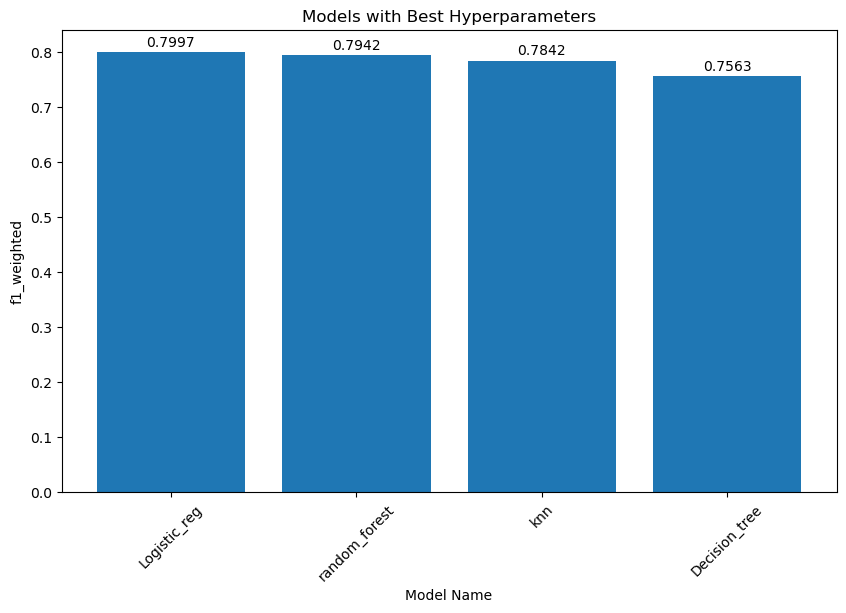

In [29]:
# Get models f1_weighted scores and names
model_names = [model_name for model_name in search_histories.keys()]
model_scores = [search_history['mean_test_f1_weighted'].max() for search_history in search_histories.values()]

# Create a DataFrame to for plot
df_models = pd.DataFrame({'model_name': model_names, 'f1_score': model_scores})
df_models = df_models.sort_values(by='f1_score', ascending=False)


# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(data=df_models, x='model_name', height='f1_score')

# Add text labels to the bars
for i, score in enumerate(df_models['f1_score']):
    plt.text(i, score+0.01, '{:1.4f}'.format(score), ha="center")

plt.xlabel('Model Name')
plt.ylabel('f1_weighted')
plt.title('Models with Best Hyperparameters')
plt.xticks(rotation=45)
plt.show()

In [30]:
metric_before_after_tuning_models = pd.merge(
    metrics_table[['model_name', 'f1_score']], 
    df_models, 
    on='model_name', 
    how='inner', 
    suffixes=('_before', '_after')
).sort_values(ascending=False, by='f1_score_after')

metric_before_after_tuning_models

,model_name,f1_score_before,f1_score_after
1,Logistic_reg,0.796963,0.799653
3,random_forest,0.779906,0.794231
2,knn,0.764687,0.784230
0,Decision_tree,0.727303,0.756317


#### Compare models before and after hyperparameter tuning using f1 score (weighted) metric

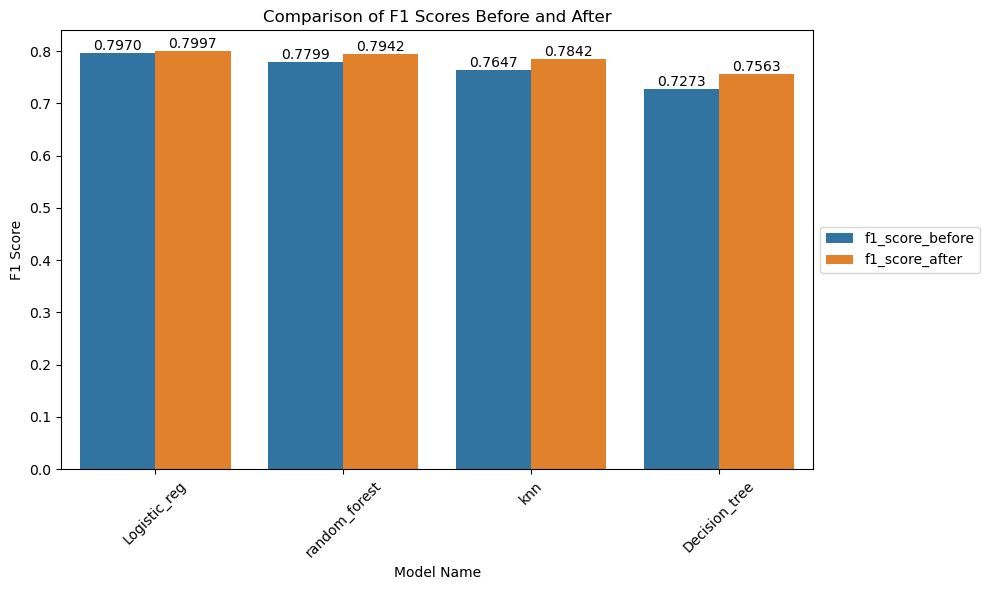

In [31]:
# Melt the DataFrame to combine f1_score_before and f1_score_after into a single column
metric_melted = metric_before_after_tuning_models.melt(id_vars='model_name', var_name='score_type', value_name='f1_score')

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the combined data
ax = sns.barplot(data=metric_melted, x='model_name', y='f1_score', hue='score_type')
plt.title('Comparison of F1 Scores Before and After')
plt.xlabel('Model Name')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

# Annotate the values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')
    
# Move legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [32]:
best_model_name = df_models['model_name'].iloc[0]
best_model = dict(best_models).get(best_model_name)
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat-encoder',
                                                                   OneH...andle_unknown='ignore'))]),
                                                  Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=300, random_state=42))])

#### Feature importances visualizations

In [58]:
# Get the feature names after transformation
feature_columns = best_model.named_steps['preprocessor'].get_feature_names_out()

# Remove unwanted prefixes and get the last part
feature_columns = np.array([col.split('__')[-1] for col in feature_columns])

# Display the feature columns
pd.DataFrame(feature_columns).rename(columns={0:'feature_columns'})


,feature_columns
0,seniorcitizen
1,tenure
2,monthlycharges
3,totalcharges
4,gender_Female
5,gender_Male
6,partner_No
7,partner_Yes
8,dependents_No
9,dependents_Yes


In [75]:
# Access the coefficients since best model is logistic regression
coefficients = best_model.named_steps['classifier'].coef_[0]

coefficients_df = pd.DataFrame({'Feature': feature_columns, 'Coefficient': coefficients})

# Magnitude of impact
coefficients_df['Absolute Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df.sort_values(by="Absolute Coefficient", ascending=False, inplace=True)

coefficients_df

,Feature,Coefficient,Absolute Coefficient
1,tenure,-1.026460,1.026460
29,contract_Month-to-month,0.647453,0.647453
31,contract_Two year,-0.619189,0.619189
15,internetservice_Fiber optic,0.526043,0.526043
16,internetservice_No,-0.471915,0.471915
2,monthlycharges,0.424311,0.424311
11,phoneservice_Yes,-0.347966,0.347966
10,phoneservice_No,0.347724,0.347724
3,totalcharges,0.336678,0.336678
24,techsupport_Yes,-0.244633,0.244633


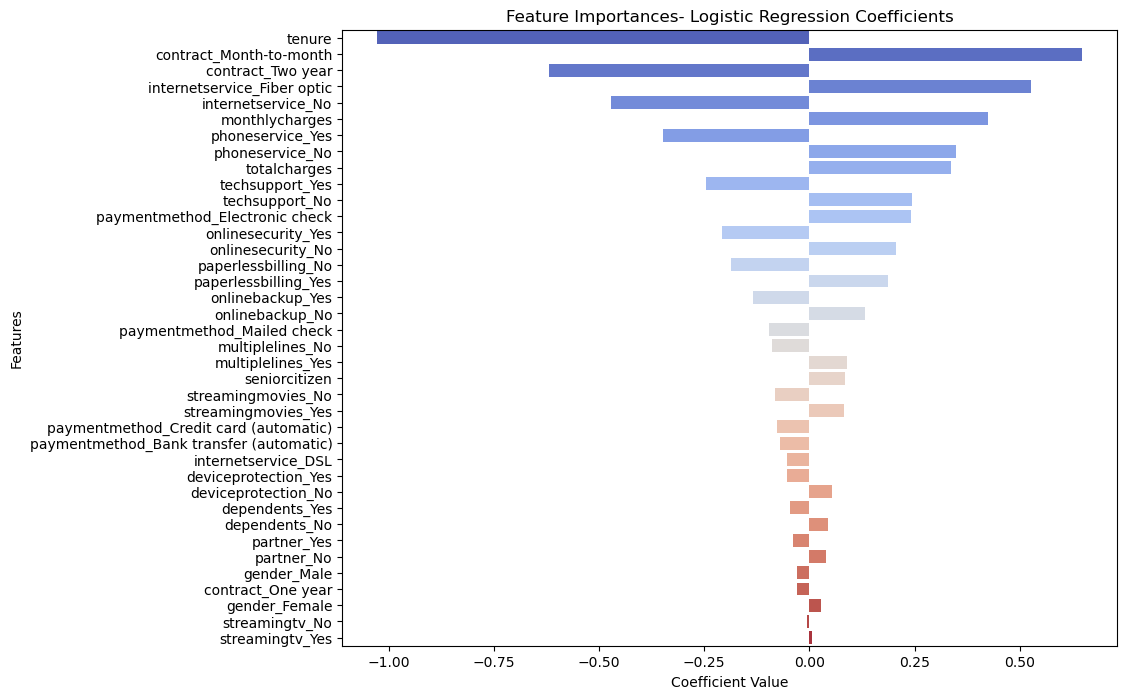

In [76]:
# Visualizing the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df, palette='coolwarm')
plt.title('Feature Importances- Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

## Understanding Feature Importances in Customer Behavior Prediction

### Overview
We utilized the best model- logistic regression to identify the most influential factors predicting customer behavior in our dataset. The coefficients from the model, presented as "feature importances," indicate how each variable impacts the likelihood of customer actions (e.g., churn or not churn).

### Key Findings

**1. Tenure**: 
- **Impact**: Most significant negative impact on the outcome (-1.026).
- **Interpretation**: Longer tenure reduces the likelihood of the predicted outcome, suggesting that longer-term customers are more stable.

**2. Contract Type**:
- **Month-to-month contracts**: Increases the likelihood of the outcome by 0.647, indicating higher volatility or turnover in short-term customers.
- **Two-year contracts**: Significant negative coefficient (-0.619), correlating with higher customer retention and stability.

**3. Internet Service**:
- **Fiber optic services**: More likely to exhibit the outcome (+0.526), potentially indicating higher expectations or different service experiences.
- **No internet service**: Negative coefficient (-0.472), reduces the likelihood, possibly due to reduced engagement with services.

**4. Billing and Payment Methods**:
- **Electronic checks**: Positive coefficient (+0.242), suggesting this payment method might be associated with more transient or less satisfied customer segments.
- **Automatic payments and mailed checks**: Show lesser significance but indicate different customer behavior patterns.

**5. Add-on Services**:
- Features like **online security**, **tech support**, and **streaming services** have varying impacts. The presence of these services generally increases or decreases the likelihood of the outcome, highlighting their influence on customer satisfaction and retention.

### Implications and Recommendations

- **Customer Retention**: Strengthen retention strategies by enhancing service offerings for long-tenure customers, particularly those in stable contract setups like two-year agreements.
- **Service Improvement**: Investigate the high impact of fiber optic services on customer behavior, focusing on improving service quality or customer support for these users.
- **Payment Flexibility**: Consider promoting automatic payment methods which appear to associate with more stable customer behavior, potentially improving overall customer satisfaction and retention.
- **Targeted Marketing**: Adjust marketing strategies to address the specific needs of different customer segments, particularly focusing on those with month-to-month contracts or using electronic checks.

#### Evaluate the best model on the evaluation set

In [33]:
y_eval_pred = best_model.predict(X_eval)
print(f'Classification report of the best model- {best_model_name}\n\n{classification_report(y_true=y_eval_encoded, y_pred=y_eval_pred)}')

Classification report of the best model- Logistic_reg

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       742
           1       0.63      0.57      0.60       267

    accuracy                           0.80      1009
   macro avg       0.74      0.73      0.73      1009
weighted avg       0.79      0.80      0.80      1009



#### Prepare the test dataset

In [34]:
test_df = pd.read_excel('Data/Telco-churn-last-2000.xlsx')

In [35]:
test_df.drop('customerID', axis=1, inplace =True)

In [36]:
test_df.columns = test_df.columns.str.lower()


In [37]:
# test_df['totalcharges'] = test_df['totalcharges'].
test_df['totalcharges'] = pd.to_numeric(test_df['totalcharges'], errors = 'coerce')

In [38]:
train_df.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,Male,0,No,No,45,No,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


#### Using the Test Data to test our model and predict churn of customers

In [39]:
predicted_churn = best_model.predict(test_df)
predicted_churn

array([1, 0, 0, ..., 1, 0, 0])

In [40]:
# Create an array of corresponding labels
labels = np.array(['No', 'Yes']) # Index 0 is No, 1 is Yes
test_df['predicted_churn'] = labels[predicted_churn]

In [41]:
test_df.head(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,predicted_churn
0,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
1,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80,No


### Visualize the predicted churn

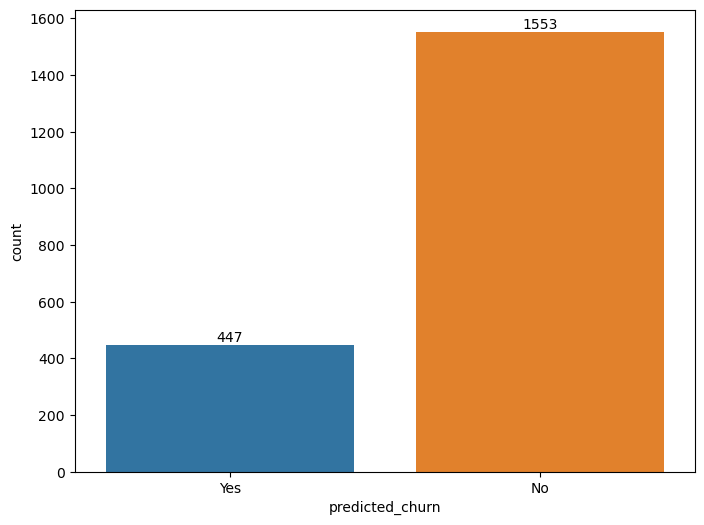

In [42]:
# Create the figure
plt.figure(figsize=(8, 6))

ax=sns.countplot(test_df, x='predicted_churn')

# Add count values on top of each bar
for p in ax.patches:
    count = int(p.get_height())  # Convert count to integer
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

#### Persist/Saving the Model

In [ ]:
import joblib

for model_name, pipeline in all_pipelines.items():
    joblib.dump(model_name,f'./Trained models/{model_name}.joblib')

    joblib.dump(encoder,f'./Trained models/encoder.joblib')

                                                